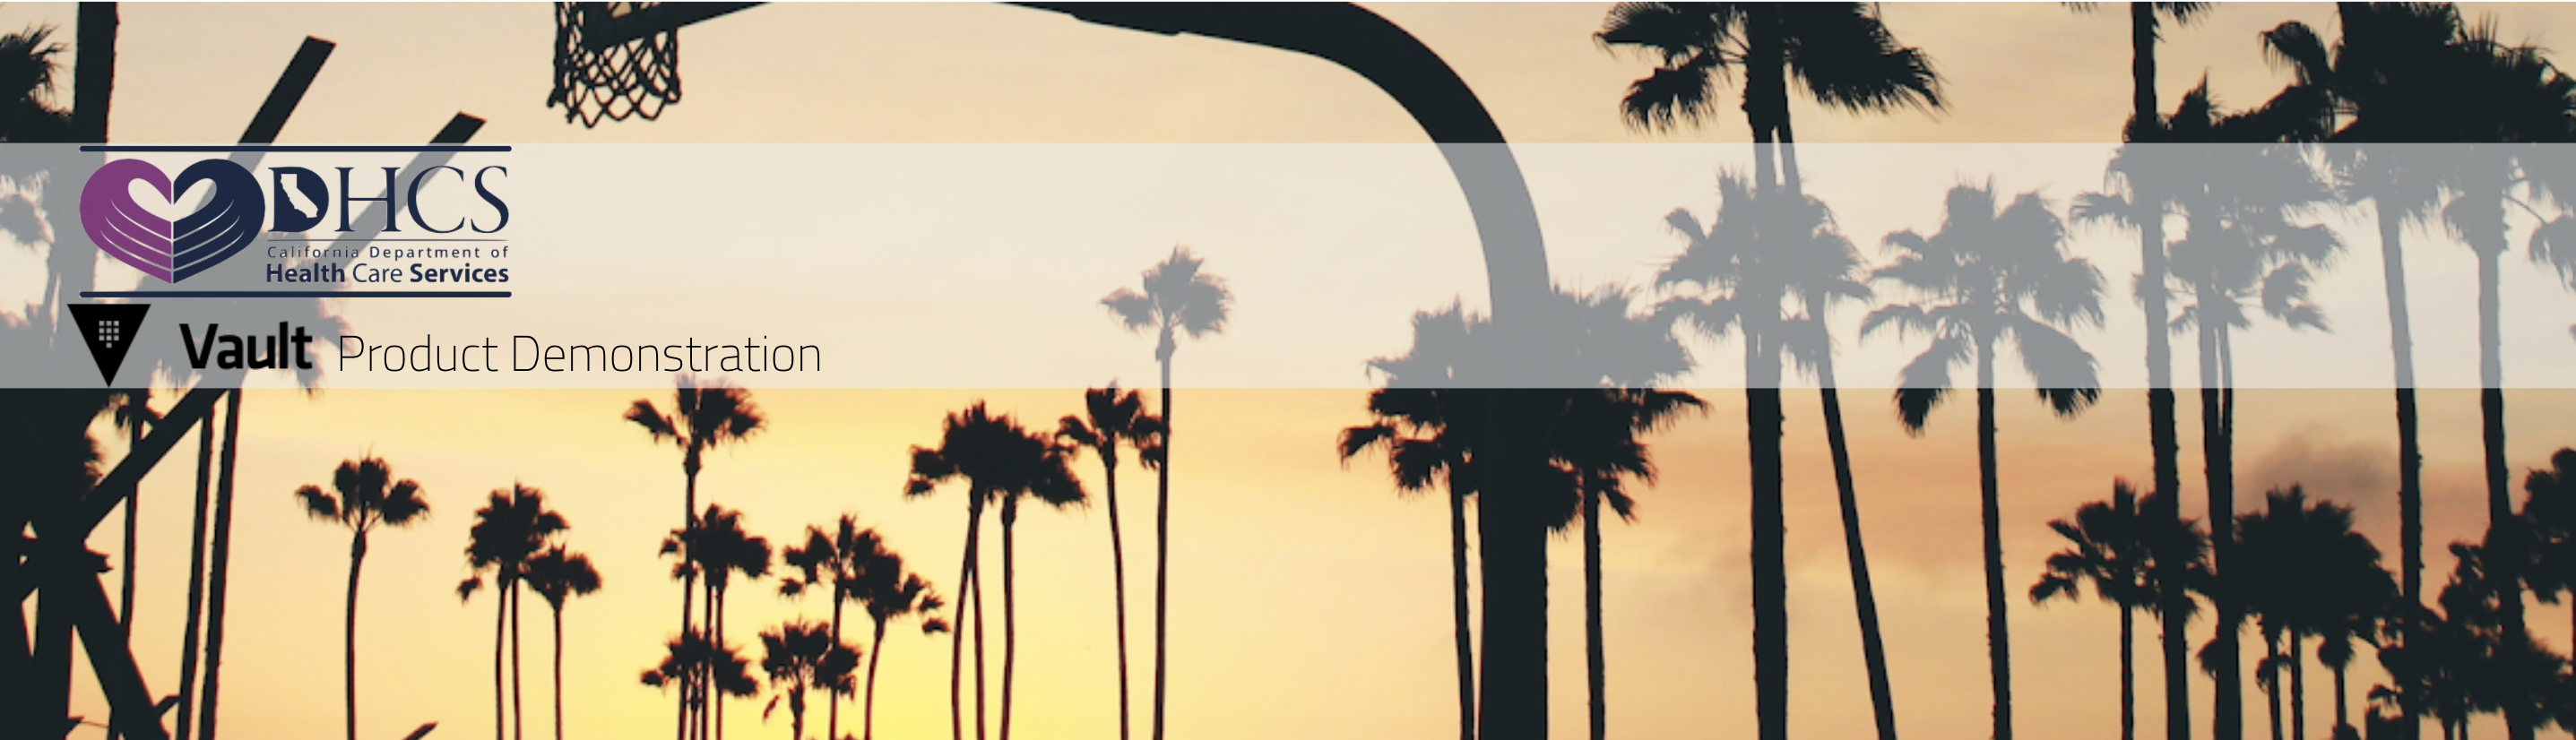

---

# Use Case: Transform Secrets Engine (Enterprise Feature)
---

## Business Value of Capability
* When you need to encrypt data and return ciphertext in a similar format
* When you need to encrypt data and return a masked form of the data

## The Challenge

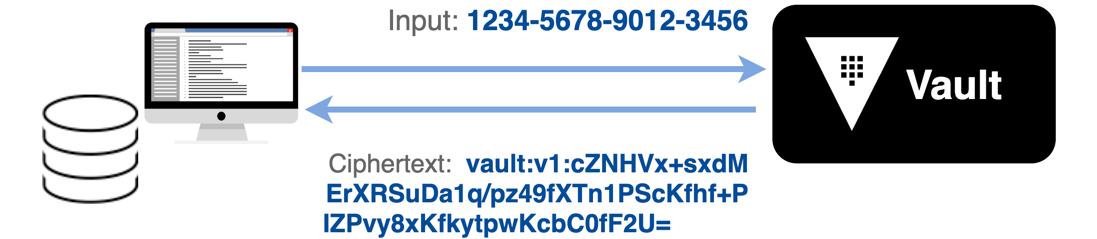

### The Solution Architecture and Result
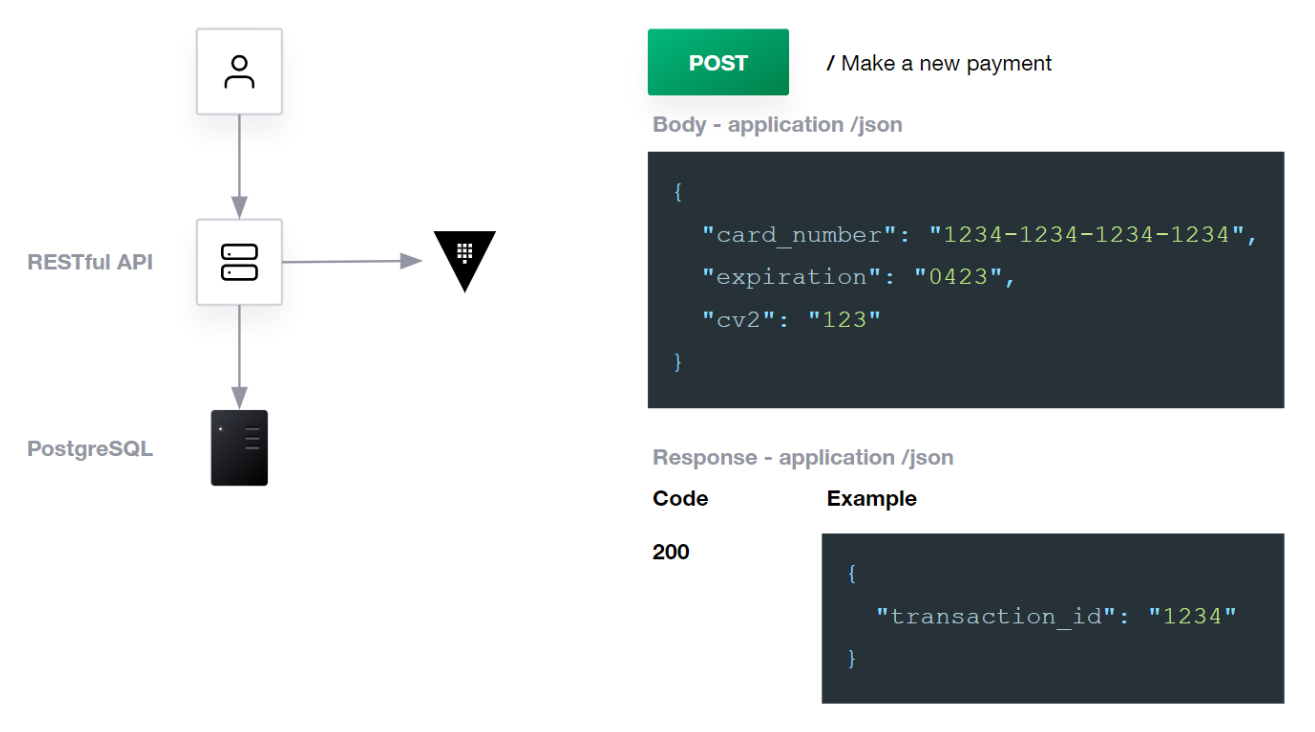

---

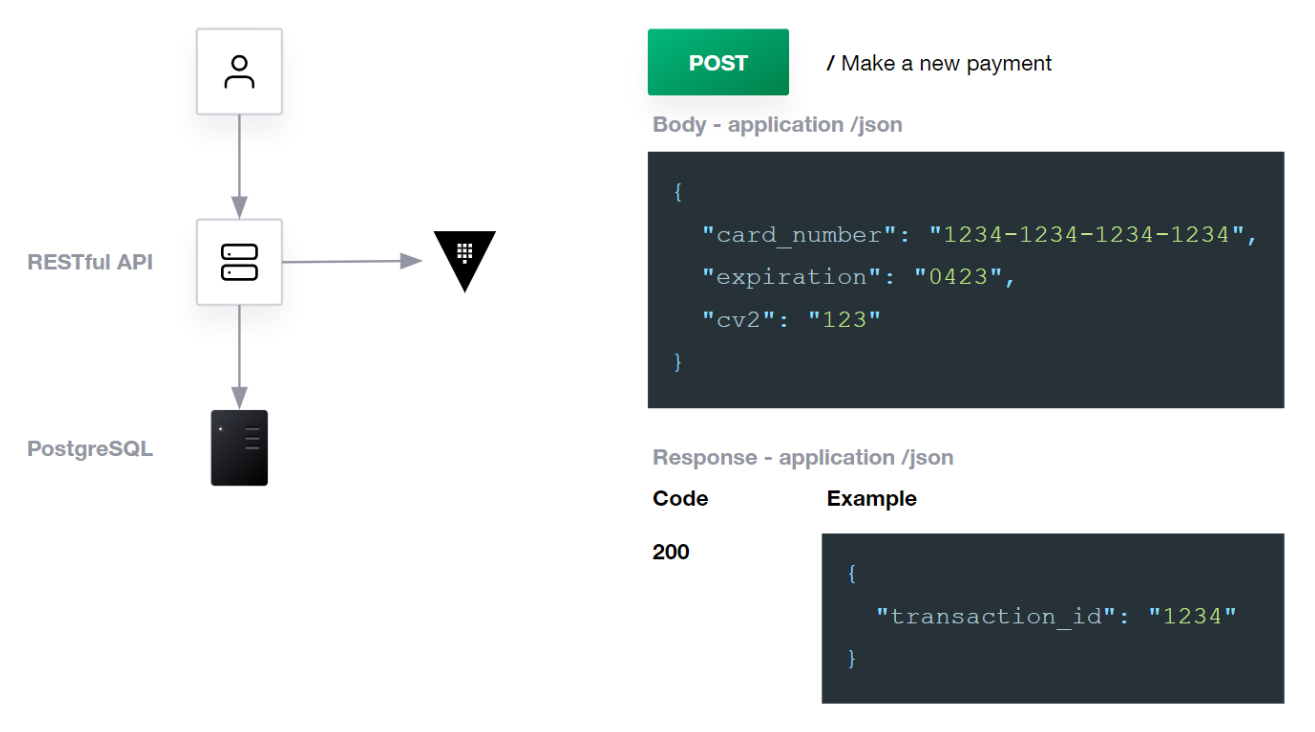

### Setup
---

The basic setup will include

1. Enable the transform secrets engine
2. Create a role containing the transformations that it can perform
3. Create an alphabet defining a set of characters to use for format-preserving encryption (FPE) if not using the built-in alphabets.
4. Create a template defining the rules for value matching if not using the built-in template
5. Create a transformation to specify the nature of the data manipulation

First we ensure we have the correct environment and binaries

In [1]:
export VAULT_ADDR=http://127.0.0.1:8200
export VAULT_TOKEN=root
export VAULT_SKIP_VERIFY=true
export LICENSE=/Users/jnyika/.licenses/vault.json

In [2]:
vault login root

WARNING! The VAULT_TOKEN environment variable is set! This takes precedence
over the value set by this command. To use the value set by this command,
unset the VAULT_TOKEN environment variable or set it to the token displayed
below.

Success! You are now authenticated. The token information displayed below
is already stored in the token helper. You do NOT need to run "vault login"
again. Future Vault requests will automatically use this token.

Key                  Value
---                  -----
token                root
token_accessor       L0ENUnGqHOC2q1lX4dr40zOU
token_duration       ∞
token_renewable      false
token_policies       ["root"]
identity_policies    []
policies             ["root"]


In [3]:
vault status

Key             Value
---             -----
Seal Type       shamir
Initialized     true
Sealed          false
Total Shares    1
Threshold       1
Version         1.6.0+ent
Storage Type    consul
Cluster Name    NC1
Cluster ID      35b0ba5a-3e58-7f38-1d50-1eda62b946a5
HA Enabled      true
HA Cluster      https://127.0.0.1:8201
HA Mode         active
Last WAL        649


In [4]:
vault -version

Vault v1.6.0+ent (d410901610b310402b6083e20d07124b0ffd6723)


In [5]:
#license the server
curl \
  --header "X-Vault-Token: root" \
  --request PUT \
  --data "@${LICENSE}" \
  http://127.0.0.1:8200/v1/sys/license

### Create Policies needed for the engine and client
Write policies to Vault

In [6]:
cat << EOF > ./config/transforms.hcl
# Work with transform secrets engine
path "transform/*" {
  capabilities = [ "create", "read", "update", "delete", "list" ]
}

# Enable secrets engine
path "sys/mounts/*" {
  capabilities = [ "create", "read", "update", "delete", "list" ]
}

# List enabled secrets engine
path "sys/mounts" {
  capabilities = [ "read", "list" ]
}
EOF

In [7]:
cat << EOF > ./config/transforms-client-policy.hcl
# To request data encoding using any of the roles
# Specify the role name in the path to narrow down the scope
path "transform/encode/*" {
   capabilities = [ "update" , "read", "list"]
}

# To request data decoding using any of the roles
# Specify the role name in the path to narrow down the scope
path "transform/decode/*" {
   capabilities = [ "update" , "read", "list" ]
}
EOF

In [8]:
vault policy write basictransforms ./config/transforms.hcl

Success! Uploaded policy: basictransforms


In [9]:
vault policy write transformsclient ./config/transforms-client-policy.hcl

Success! Uploaded policy: transformsclient


### Demo
---

### Step 1: Enable Transforms Engine  
(Persona: Operations)

In [10]:
vault secrets enable transform

Success! Enabled the transform secrets engine at: transform/


### Step 2: Create a 2 roles containing transforms 
(Persona: Operations)
* One role to encrypt standard CC numbers. 
* Another role for a custom operator IDentifier - possibly for a mission

In [11]:
vault write transform/role/payments transformations=card-number

Success! Data written to: transform/role/payments


In [12]:
vault write transform/role/operators transformations=tfoperatorcode

Success! Data written to: transform/role/operators


### Step 3: Create a custom template we shall use for the mission
(Persona: Operations)
 Each operator is assigned a unique code of the form OP-XXX-XXXXXXX-XXX where X is a number

In [13]:
vault write transform/template/operatorcode \
type=regex \
pattern='OP-(\d{3})-(\d{7})-(\d{3})' \
alphabet="builtin/numeric"

Success! Data written to: transform/template/operatorcode


#### Tie the template to a transfromation instruction for a particular role

In [14]:
vault write transform/transformation/tfoperatorcode \
        type=fpe \
        template="operatorcode" \
        tweak_source=generated \
        allowed_roles=operators

Success! Data written to: transform/transformation/tfoperatorcode


### Step 4: Create the transformation as well for CC numbers
(Persona: Operations)

In [15]:
vault write transform/transformation/card-number \
        type=fpe \
        template="builtin/creditcardnumber" \
        tweak_source=generated \
        allowed_roles=payments

Success! Data written to: transform/transformation/card-number


### Step 5: EXAMPLE: Encode a CC Number

In [16]:
vault write transform/encode/payments value=1111-2222-3333-4444 

Key              Value
---              -----
encoded_value    0998-6584-0229-8689
tweak            H+3ooTdKTg==


In [20]:
vault write transform/decode/payments value=0998-6584-0229-8689 tweak=H+3ooTdKTg==

Key              Value
---              -----
decoded_value    1111-2222-3333-4444


### Step 6: EXAMPLE: Encode an Operator Code

In [18]:
vault write transform/encode/operators value=OP-556-8473840-644

Key              Value
---              -----
encoded_value    OP-744-1091759-516
tweak            wKXlbPtA1g==


In [21]:
vault write transform/decode/operators value=OP-744-1091759-516 tweak=wKXlbPtA1g==

Key              Value
---              -----
decoded_value    OP-556-8473840-644


### Step 7: Modify to use Masking character for operator codes (*)

## **Masking is a unidirectional operation; therefore, encode is the only supported operation.**

In [22]:
vault write transform/role/operators transformations=tfmaskoperatorcode

Success! Data written to: transform/role/operators


In [23]:
vault write transform/transformation/tfmaskoperatorcode \
        type=masking \
        template="operatorcode" \
        masking_character=▓ \
        allowed_roles=*

Success! Data written to: transform/transformation/tfmaskoperatorcode


In [24]:
vault write transform/encode/operators value='OP-994-8595836-223'

Key              Value
---              -----
encoded_value    OP-▓▓▓-▓▓▓▓▓▓▓-▓▓▓


---

We have demonstrated
1. **Using FPE built ins**
1. **Using Custom templates**
1. **Using Masking**

### Step 8: Tear Down demo

In [25]:
vault secrets disable transform

Success! Disabled the secrets engine (if it existed) at: transform/


**END**